test.img

    0x0000 - 0x01FE    FAT16 Boot Record
        --------------------------------------
        Start:            0x0000
        Reserved Sectors: 0x0400
        Sectors per FAT:  0xF200
        Maximum Root Directory Entries: 2
        Bytes Per Sector: 2
        --------------------------------------
        Fat Tables:      0x0400  --> maybe 0x200 instead
        Root Dir.:       hex(0x400+2*0xF200)          = 0x1e800
        Data Area:       hex(0x400+2*0xF200+2*32//2)  = 0x1e820
        
    0x0200

# Header

Starting from 0xC800, there seems to be a 0x200 size header block for each animation

    ---------------------------------------------------------------------
    0001 02 03 0405060708 09 0A 0B 0C 0D 0E 0F 10 11 12 13 <string name> <0x00 padding>
    ---------------------------------------------------------------------
    0001 01 58 000061A870 57 20 02 01 01 01 2E 03 2F 3B 01 24_001              0x0012C400
    0002 01 2C 0000630938 57 20 02 01 01 01 5A 0A 01 2C 01 24_002              0x0013EE00
    0003 01 06 000063BA18 29 20 01 00 00 00 00 00 00 00 00 24_003              0x00143000
    0004 01 0A 000063D31E 22 20 01 00 00 00 00 00 00 00 00 24_004              0x00148800
    0005 01 05 000063FC1E 83 20 01 00 00 00 00 00 00 00 01 24_005              0x00151A00
    0006 01 29 0000641129 57 20 02 01 01 01 05 0A 01 29 01 24_006
    0007 01 08 000064B630 AE 20 01 00 00 00 00 00 00 00 01 24_007
    0008 01 1D 000064D71D 17 1D 02 01 01 01 03 0A 01 23 01 24_008
    0009 01 3F 0000654C50 57 20 02 01 01 01 03 0A 01 3F 00 24_009
    000A 01 10 0000664910 80 20 01 01 01 00 00 00 00 00 00 AC#DC_001           0x00172C00
    000B 01 20 0000668A20 80 20 01 01 00 00 00 00 00 00 00 AC#DC_002
    022E 01 01 0000FFFD01 80 20 01 00 00 00 00 00 00 00 00 FLINTSTONES_024
    022F 01 01 0001000201 80 20 01 00 00 00 00 00 00 00 00 FLINTSTONES_025
    0230 01 01 0001000701 80 20 01 00 00 00 00 00 00 00 00 FLINTSTONES_026
    08FC 01 23 00034AB723 80 20 01 01 00 00 00 00 00 00 00 X-MEN_063
    08FD 01 14 00034B4414 80 20 01 00 00 00 00 00 00 00 00 X-MEN_064
    08FE 01 39 00034B9539 80 20 00 01 01 00 00 00 00 00 00 X-MEN_065


        0001 : Animation ID
          02 : Always 1
          03 : Animation length [frames]
    04050607 : Some kind of offset ??
          09 : xResolution [pixels]
          0A : yResolution [pixels]

# Animation offsets
    
    0x12C400: Start of first frame of first animation
    0x13EE00: Start of first frame of second animation
    0x143000: Start of first frame of third animation
    0x148800
    




__Strange data blocks at the end of an animation__
    
    0013EC00   01 32 02 32  03 32 04 32  05 32 06 32  07 32 08 32  .2.2.2.2.2.2.2.2
    0013EC10   01 32 02 32  03 32 04 32  05 32 06 32  07 32 08 32  .2.2.2.2.2.2.2.2
    0013EC20   01 32 02 32  03 32 04 32  05 32 06 32  07 32 08 32  .2.2.2.2.2.2.2.2
    0013EC30   01 32 02 32  03 32 04 32  05 32 06 32  07 32 08 32  .2.2.2.2.2.2.2.2
    0013EC40   01 32 02 32  03 32 04 32  05 32 06 32  07 32 08 32  .2.2.2.2.2.2.2.2
    0013EC50   01 32 02 32  03 32 04 32  05 32 06 32  07 32 08 32  .2.2.2.2.2.2.2.2
    
    00142E00   01 69 02 32  03 32 04 32  05 32 06 32  07 32 08 32  .i.2.2.2.2.2.2.2
    00142E10   09 32 0A 32  0B 6E 0C 69  0D 32 0E 32  0F 32 10 32  .2.2.n.i.2.2.2.2
    00142E20   11 32 12 32  13 32 14 32  15 69 16 32  17 32 18 32  .2.2.2.2.i.2.2.2
    00142E30   19 32 1A 32  1B 32 1C 32  1D 73 00 00  00 00 00 00  .2.2.2.2.s......
    
    00151800   01 32 02 32  03 32 04 32  05 32 06 32  07 32 08 32  |.2.2.2.2.2.2.2.2|
    00151810   09 32 0a 32  0b 32 0c 32  0d 32 0e 32  0f 32 10 32  |.2.2.2.2.2.2.2.2|
    00151820   11 32 12 32  13 32 14 32  15 32 16 32  17 32 18 32  |.2.2.2.2.2.2.2.2|
    00151830   19 32 1a 32  1b 32 1c 32  1d 32 1e 32  1f 32 20 32  |.2.2.2.2.2.2.2 2|
    00151840   21 32 22 32  23 32 24 32  25 32 26 32  27 32 28 32  |!2"2#2$2%2&2'2(2|
    00151850   29 32 2a 32  2b 32 2c 32  2d 32 2e 32  2f 32 30 32  |)2*2+2,2-2.2/202|
    00151860   31 32 32 32  33 32 34 32  35 32 36 32  37 32 38 32  |1222324252627282|
    00151870   39 32 3a 32  3b 32 3c 32  3d 32 3e 32  3f 32 2f 32  |92:2;2<2=2>2?2/2|
    00151880   30 32 31 32  32 32 33 32  34 32 35 32  36 32 37 32  |0212223242526272|
    00151890   38 32 39 32  3a 32 3b 32  3c 32 3d 32  3e 32 3f 32  |8292:2;2<2=2>2?2|
    001518a0   00 00 00 00  00 00 00 00  00 00 00 00  00 00 00 00  |................|
    
    
    
    


In [650]:
%pylab
import time
import matplotlib.animation as animation

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/michael/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [348]:
#fName = "./ani.raw.data"
fName = "/home/michael/Desktop/older.img"
with open(fName,"rb") as f:
    rawDat = array( bytearray(f.read()), dtype=uint8 )

In [685]:
def hexDump( buffer ):
    """ Print a pretty hex-dump on the debug out """
    for i,b in enumerate(buffer):
        if len(buffer)>16 and (i%16)==0:
            print( "\n    {:04x}: ".format(i), end='' )
        print( "{:02x} ".format(b), end='' )

def getFrame( buf, xSize=128, ySize=32, frameOffset=0, byteOffset=None ):
    """ returns unpacked image data, 1 byte per pixel """
    if byteOffset is None:
        byteOffset = xSize*ySize*frameOffset
    rawDat = buf[byteOffset:byteOffset+ySize*xSize//2]
    # unpack 2 pixels / byte to 1 pixel / byte
    a = zeros(xSize*ySize, dtype=uint8)
    a[1::2] = rawDat & 0x0F
    a[0::2] = rawDat >> 4
    return a.reshape((ySize,xSize))

def isFooter( dat ):
    """ returns >= 0 if a footer frame of size 0x200 bytes is detected """
    tag = b"\x01\x02\x03\x04\x05"
    a = b"".join( dat.flatten()[:128*32//2][0::2] )
    b = b"".join( dat.flatten()[:128*32//2][1::2] )
    ind = a.find( tag )
    if ind >= 0:
        return 2*ind
    ind = b.find( tag )
    if ind >= 0:
        return 2*ind+1
    return ind

fNameOffset = 0xC814
def getNextFname():
    global fNameOffset
    fName = b"".join( rawDat[fNameOffset:fNameOffset+32] ).replace(b"\x00",b"").decode("ascii")
    fNameOffset += 0x200
    return fName

# Animated plot

In [687]:
close("all")
figure( figsize=(8,2))
d = imshow( zeros((ySize,xSize)), aspect="equal", vmin=0, vmax=15, interpolation="hanning", cmap=cm.binary_r )

fNameOffset = 0
xSize = 128
ySize = 32   #len(rawDat)
frameSize = xSize * ySize // 2
offset = 0x12C400
def ani(x):
    global offset
    aniDat = rawDat[offset:offset+frameSize]
    fOffs = isFooter( aniDat )
    if fOffs >= 0:
        offset += fOffs + 0x200
        return
    d.set_data( getFrame(aniDat, xSize, ySize) )
    offset += frameSize

#ani = animation.FuncAnimation(gcf(), ani, interval=50 )

In [668]:
from PIL import Image

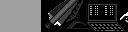

In [682]:
img = Image.fromarray( getFrame(rawDat, byteOffset=offset+3*frameSize)*16 )
img

In [910]:
img.mode

'L'

In [885]:
0xA*16

160

In [ ]:
xSize = 128
ySize =  32
frameSize = xSize * ySize // 2
offset = 0x12C400
fNameOffset = 0xC814
imlist = []
while(1):
    aniDat = rawDat[offset:offset+frameSize]
    if len(aniDat) < frameSize:
        print("done")
        break
    fOffs = isFooter( aniDat )
    if fOffs >= 0:
        # end of current file, save it
        fName = "./gif/{}.gif".format( getNextFname() )
        print( hex(offset), fName )
        imlist[0].save( fName, save_all=True, append_images=imlist[1:] )
        #start a new file
        imlist = []
        offset += fOffs + 0x200
    else:
        imgData = getFrame(aniDat, xSize, ySize) * 16
        imlist.append( Image.fromarray(imgData, mode="L") )
        offset += frameSize

In [916]:
hex(offset)

'0x77ffc00'

In [497]:
isFooter( rawDat[0x383400:] )

0

In [691]:
d.set_data( getFrame(rawDat, byteOffset=0x151a00+frameSize*4) )

In [374]:
ftr = getFrame(rawDat, byteOffset=0x1A2A00 + frameSize*0 )
frm = getFrame(rawDat, byteOffset=0x1A2A00 + frameSize*-1 )

In [376]:
isFooter( ftr )

True

In [879]:
i=0
startOffset = 0x188600

In [882]:
frm = getFrame(rawDat, byteOffset=startOffset+frameSize*i)
d.set_data( frm )
print(hex(i))
print(hex(startOffset+frameSize*i))
i += 1

0x2
0x189600
